In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# A Touch of Perturbation theory

Perturbation is taking a problem you know how to solve and then using that to bootstrap yourself into a problem you can't solve.
The simplest equation we can use perturbation theory on is $(a+b)x = c$. The answer, by the way, is $x = \frac{c}{a+b}$ so there is absolutely no reason to throw perturbation theory at this one. But it is illuminating I think.

So a simple methodology to generate an iterative method is to take an equation and isolate the variable on one side. Then set the left side to $x_{n+1}$ and the right side to $x_{n}$. Now of course, this isn't guaranteed to be a good method or to converge even. But, IF it does converge, then you have found a solution. So just give it a try.

$x_{n+1} = \frac{1}{a} (c-bx_{n})$

$x = \frac{c}{a}(1- \frac{b}{a} + (\frac{b}{a})^2 - (\frac{b}{a})^3 + \dots)$

This thing has also generated a power series in b/a. This is a perturbation series in this parameter. We can write a python function to return these partial sums

In [2]:
def simple_solve(a,b,c, iters=10):
    x = [0]
    for i in range(iters):
        x.append((c-b*x[-1])/a)
    return x

print(simple_solve(2,1,1)) # answer is 1/(1+2) = 0.33333


[0, 0.5, 0.25, 0.375, 0.3125, 0.34375, 0.328125, 0.3359375, 0.33203125, 0.333984375, 0.3330078125]


A converging solution

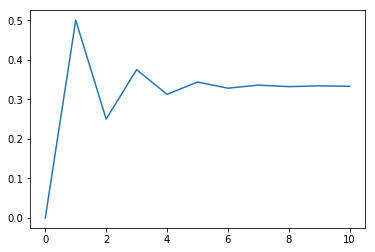

In [3]:
plt.plot(simple_solve(2,1,1))

Now, if b/a gets too big, this perturbation series may not converge. Check it out. An oscillatory solution.

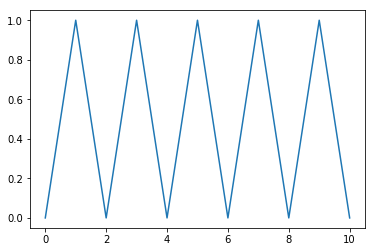

In [4]:
plt.plot(simple_solve(1,1,1))

A divergent solution

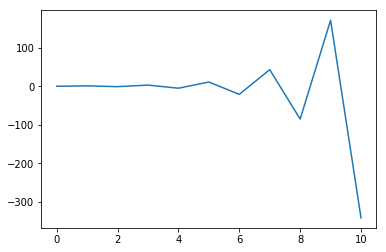

In [5]:
plt.plot(simple_solve(1,2,1))

### Python Generator Town
There is a really cute trick for sequences. We can use generators to hold even infinite sequences, with the acknowledgement that we'll only ever look at a finite part of them. This is the python version of Haskell's infinite lists.

In [3]:
def linear_terms(a,b,c):
    x = 0
    while True:
        yield x
        x = (c-b*x)/a

In [5]:
from itertools import islice, count
import itertools as seq

In [6]:
list(islice(linear_terms(2,1,1),20))

[0,
 0.5,
 0.25,
 0.375,
 0.3125,
 0.34375,
 0.328125,
 0.3359375,
 0.33203125,
 0.333984375,
 0.3330078125,
 0.33349609375,
 0.333251953125,
 0.3333740234375,
 0.33331298828125,
 0.333343505859375,
 0.3333282470703125,
 0.33333587646484375,
 0.3333320617675781,
 0.33333396911621094]

Or we can similarly output just the individual terms and sum them up later.

In [9]:
def linear_term2(a,b,c):
    t = c/a
    while True:
        yield t
        t = -t * b/a 

        

In [10]:
sum(islice(linear_term2(2,1,1),20))

0.33333301544189453

Power series are a pretty interesting use of iterators. You can use them to form products, sums, derivatives and integrals, and most interestingly inverses. [check it out](http://www.cs.dartmouth.edu/~doug/powser.html)

## Perturbation of Matrix Equations
This very naturally extends to Matrices.
Suppose we have the equation
$Ax+Bx=c$
where $A$ is an easily invertible matrix
Then we can form the same iterative equation, upping everything to Matrices and vectors.

$x_{n+1} = A^{-1} (c-Bx_{n})$

In a sense, we are doing the original scalar perturbation series for all of the eigenvalues of the system in parallel. And we may anticipate the series diverging is any of the eigenvalues does.

The is called the Born Series in physics

In [ ]:
def linear_term_mat(a,b,c):
    x = 0
    while True:
        yield x
        x = np.linalg.solve(a,c - b@x)

In [41]:
def linear_term_mat2(ainv,b,c):
    x = 0
    while True:
        yield x
        x = ainv@(c - b@x)
def linear_term_mat3(ainv,b):
    N = b.shape[0]
    x = np.zeros((N,N))
    while True:
        yield x
        x = ainv@(np.eye(N) - b@x)

In [ ]:
def ser_to_powser(ser):
    temp = 0
    for s in ser:
        temp = s - temp
        yield temp
def powser_to_ser(powser):
    acc = 0
    for s in powser:
        acc += s
        yield acc
        

However we implemented these operators as functions.

In [ ]:
def linear_term_fun(ainv,b,c):
    x = 0
    while True:
        yield x
        x = ainv(c - b(x))

In [ ]:
def seqfix(f):
    for x in f(x, seqfix(f)): #ok looks plausible but x is not in scope in the right part.
        yield x
def seqfix(f):
    def retgen(x):
        for s in f(x, seqfix(f)):
            yield s
    return retgen
    


In [37]:
from scipy.linalg import circulant
NSites = 6
eps = 1.0
t = 0.5

firstcol = np.zeros(NSites)
firstcol[0] = eps
firstcol[1] = t
firstcol[-1] = t

H0 = circulant(firstcol) #Takes first column and repeats it shifted
print(oneH)

[[ 1.   0.5  0.   0.   0.   0.5]
 [ 0.5  1.   0.5  0.   0.   0. ]
 [ 0.   0.5  1.   0.5  0.   0. ]
 [ 0.   0.   0.5  1.   0.5  0. ]
 [ 0.   0.   0.   0.5  1.   0.5]
 [ 0.5  0.   0.   0.   0.5  1. ]]


Now let's consider a random potential 

In [31]:
V = np.diag(np.random.randn(NSites)) * 0.1

The Green's function relevant to quantum mechanics is a matrix parametrized by the parameter E. 

In [56]:
def G0(E):
    N = H0.shape[0]
    I = np.eye(N)
    return np.linalg.inv(H0 - E*I)

In [61]:
def G(E):
    N = H0.shape[0]
    I = np.eye(N)
    return np.linalg.inv(H0 + V - E*I)

In [25]:
def G0Adv(E, eps=0.01):
    return G(E+1.j*eps)

In [35]:
def GSeq(E):
    return linear_term_mat3(G0(E),V)

In [58]:
seqprint(GSeq(100))

[array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]]), array([[ -1.01015254e-02,  -5.10191067e-05,  -2.57685402e-07,
         -2.60288285e-09,  -2.57685402e-07,  -5.10191067e-05],
       [ -5.10191067e-05,  -1.01015254e-02,  -5.10191067e-05,
         -2.57685402e-07,  -2.60288285e-09,  -2.57685402e-07],
       [ -2.57685402e-07,  -5.10191067e-05,  -1.01015254e-02,
         -5.10191067e-05,  -2.57685402e-07,  -2.60288285e-09],
       [ -2.60288285e-09,  -2.57685402e-07,  -5.10191067e-05,
         -1.01015254e-02,  -5.10191067e-05,  -2.57685402e-07],
       [ -2.57685402e-07,  -2.60288285e-09,  -2.57685402e-07,
         -5.10191067e-05,  -1.01015254e-02,  -5.10191067e-05],
       [ -5.10191067e-05,  -2.57685402e-07,  -2.60288285e-09,
         -2.57685402e-07,  -5.10191067e-05,  -1.01015254e-02]]), array([[ -1

In [65]:
list(seq.islice(GSeq(-1),10))[9] - G(-1)

array([[ -2.50659493e-11,   1.63128400e-11,  -6.52186014e-11,
          1.87296536e-10,  -4.10761494e-11,   1.58913438e-11],
       [  1.63128122e-11,  -1.53672630e-11,   6.85265455e-11,
         -1.98791268e-10,   4.31352801e-11,  -1.43384610e-11],
       [ -6.52186014e-11,   6.85266011e-11,  -3.04945735e-10,
          8.85429979e-10,  -1.91837247e-10,   6.20563913e-11],
       [  1.87296529e-10,  -1.98791240e-10,   8.85429924e-10,
         -2.57125288e-09,   5.56998753e-10,  -1.79696820e-10],
       [ -4.10761564e-11,   4.31352801e-11,  -1.91837254e-10,
          5.56998808e-10,  -1.20671695e-10,   3.90471544e-11],
       [  1.58913438e-11,  -1.43384471e-11,   6.20563774e-11,
         -1.79696841e-10,   3.90471822e-11,  -1.32447386e-11]])

If we compare the 10th element in the series to the numpy numerical result, they agree strongly

In [74]:
next(seq.islice(GSeq(-1),10,10+1)) - G(-1)

array([[ -2.32835973e-12,   1.81157866e-12,  -7.57351820e-12,
          2.18564611e-11,  -4.76722134e-12,   1.70816139e-12],
       [  1.81155091e-12,  -1.82531767e-12,   7.99132982e-12,
         -2.31778138e-11,   5.02673944e-12,  -1.65022856e-12],
       [ -7.57351126e-12,   7.99132982e-12,  -3.55476759e-11,
          1.03217074e-10,  -2.23619526e-11,   7.22702800e-12],
       [  2.18564507e-11,  -2.31777930e-11,   1.03217102e-10,
         -2.99733571e-10,   6.49310050e-11,  -2.09531420e-11],
       [ -4.76722828e-12,   5.02673597e-12,  -2.23619664e-11,
          6.49310605e-11,  -1.40676359e-11,   4.54714044e-12],
       [  1.70816139e-12,  -1.65023550e-12,   7.22702106e-12,
         -2.09531559e-11,   4.54714044e-12,  -1.50901514e-12]])

In [82]:
def getNth(sequence, N):
    return next(seq.islice(sequence,N,N+1))

In [53]:
np.linalg.eigvals(H0)

array([ -1.66533454e-16,   5.00000000e-01,   2.00000000e+00,
         1.50000000e+00,   5.00000000e-01,   1.50000000e+00])

The magnitude of the error decreases with increasing terms.

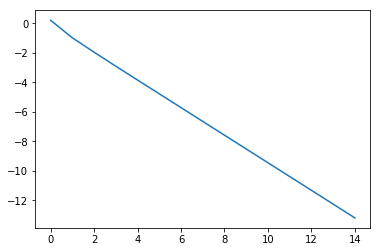

In [81]:
plt.plot(np.log10(np.linalg.norm(np.array(list(seq.islice(GSeq(-1),15))) - G(-1).reshape((-1,NSites,NSites)), axis=(1,2))))

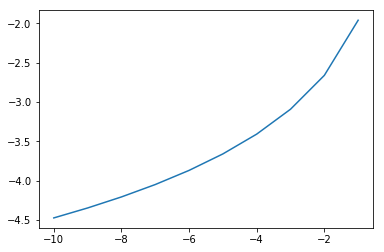

In [93]:
Es = np.arange(10)*-1 -1
perturbOrder = 2
plt.plot(Es, np.log10(list(map(lambda E: np.linalg.norm(np.array(getNth(GSeq(E),perturbOrder)) - G(E)), Es))))

In [96]:
from feynman import Diagram

ModuleNotFoundError: No module named 'feynman'

In [ ]:
class Diagram():
    def __init__(self):
        self.inputs = []
        self.outputs = []
    
    def __add__(self,b):
        #return diagrams with plus sign in between
        pass
    def __matmul__(self,b):
        #return diagrams with inputs attached to outputs  
        pass